In [1]:
##########################################
#Step 0: Import libraries
##########################################

In [2]:
#generic data analysis 
import os
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

In [3]:
#Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.neighbors import KNeighborsClassifier

# Reporting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [4]:
##########################################
#Step 1: Import data
##########################################

In [5]:
#Setting directory
directory = r'C:\Users\jlenehan\OneDrive - Intel Corporation\Documents\0 - Data Science\Data Analytics Essentials\UCDPA_JohnLenehan\UCDPA_JohnLenehan'
os.chdir(directory)

In [6]:
#importing car crash data from chicago data portal
#url to overview page - https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
collision_json = r'https://data.cityofchicago.org/resource/85ca-t3if.json?$limit=1000000' #json url

#using read_json function to read in dataset
collision_raw = pd.read_json(collision_json) #reading collisions json

In [7]:
print(collision_raw.head())

                                     crash_record_id               crash_date  \
0  0033638c9c11555c2569a8efbf2166f85db0342bb8bf60...  2023-05-17T23:32:00.000   
1  bfcebac2b9d23aca04946ea9c31b4a6aea169664c8e858...  2023-05-17T23:25:00.000   
2  a4be78f56ebfb4a8e219edf88b0fe318ee87f048d3ebe4...  2023-05-17T22:45:00.000   
3  23a4bf217800a3ff0057558aee4b093991cb63657b93e0...  2023-05-17T22:31:00.000   
4  da1f16c2f01c509fbc6e690845115ea124f3d106593251...  2023-05-17T22:15:00.000   

   posted_speed_limit traffic_control_device device_condition  \
0                  35            NO CONTROLS      NO CONTROLS   
1                  30            NO CONTROLS          UNKNOWN   
2                  30            NO CONTROLS      NO CONTROLS   
3                  30            NO CONTROLS      NO CONTROLS   
4                  30            NO CONTROLS      NO CONTROLS   

  weather_condition      lighting_condition          first_crash_type  \
0             CLEAR  DARKNESS, LIGHTED ROAD      

In [8]:
#importing beat data to join to main dataset
#source - Chicago Data Portal
#beat data url - https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74
beat_data=pd.read_csv('PoliceBeatDec2012.csv')

print(beat_data.info())
print(beat_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   the_geom  277 non-null    object
 1   DISTRICT  277 non-null    int64 
 2   SECTOR    277 non-null    int64 
 3   BEAT      277 non-null    int64 
 4   BEAT_NUM  277 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.9+ KB
None
         DISTRICT      SECTOR        BEAT     BEAT_NUM
count  277.000000  277.000000  277.000000   277.000000
mean    12.122744    2.028881    2.028881  1235.241877
std      7.232131    0.924249    0.924249   722.945828
min      1.000000    0.000000    0.000000   111.000000
25%      6.000000    1.000000    1.000000   633.000000
50%     11.000000    2.000000    2.000000  1131.000000
75%     18.000000    3.000000    3.000000  1813.000000
max     31.000000    5.000000    5.000000  3100.000000


In [9]:
##########################################
#Step 2: Merge Data
##########################################

In [10]:
#joining collision data to beat data - inner join
collisions = collision_raw.merge(beat_data, how='inner',
                                 left_on='beat_of_occurrence',
                                 right_on='BEAT_NUM'
                                 )

print(collisions.head())

                                     crash_record_id               crash_date  \
0  0033638c9c11555c2569a8efbf2166f85db0342bb8bf60...  2023-05-17T23:32:00.000   
1  812152b35726379692b6da74902134f691f007a346efc7...  2023-05-15T17:35:00.000   
2  175d918f7e32b12578e912f439a3c693ed1c919a8ef565...  2023-05-14T17:30:00.000   
3  26091c45d44fee09d76d1154102d639f7a80747ecf5a1b...  2023-05-14T10:57:00.000   
4  7bed5e0b28cda55572b9a49657e8ff897cacaf88f07104...  2023-05-11T18:00:00.000   

   posted_speed_limit traffic_control_device      device_condition  \
0                  35            NO CONTROLS           NO CONTROLS   
1                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
2                  25            NO CONTROLS           NO CONTROLS   
3                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
4                  25            NO CONTROLS           NO CONTROLS   

  weather_condition      lighting_condition          first_crash_type  \
0             CLEAR

In [11]:
#alternatively - can get district from first 2 digits of beat of occurrence
#collisions['district'] = collisions['beat_of_occurrence'].astype(str).str.extract(r'^(\d{2})')

In [12]:
##########################################
#Step 3: Describe data
##########################################

In [13]:
#Describe recent incidents dataset
print(collisions.columns)
print(collisions.info())
print(collisions.describe())
print(collisions.shape)


Index(['crash_record_id', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'damage', 'date_police_notified',
       'prim_contributory_cause', 'sec_contributory_cause', 'street_no',
       'street_direction', 'street_name', 'beat_of_occurrence', 'num_units',
       'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown', 'crash_hour', 'crash_day_of_week', 'crash_month',
       'latitude', 'longitude', 'location', 'intersection_related_i',
       'hit_and_run_i', 'photos_taken_i', 'statements_taken_i',
       'private_property_i', 'crash_date_est_i', 'work_zone_i',
       'work_zone_type', 'workers_present_i', 

In [14]:
#defining custom function to print all unique values and their counts from each column
def print_uniques(df):
    #for large datasets - using generator object for speed
    uniques_generator = ((x, df[x].unique(), df[x].nunique()) for x in df.columns)
    
    print('\nUnique Values:')
    for x, unique_values, num_unique in uniques_generator:
        print(f"{x}: \n {unique_values} \n ({num_unique} unique values)")


In [15]:
#converting location data to string
collisions['location'] = collisions['location'].astype(str)

#calling custom function on collisions df
print_uniques(collisions)


Unique Values:
crash_record_id: 
 ['0033638c9c11555c2569a8efbf2166f85db0342bb8bf6028c43a143f6d8de1e8ef9a850a2f04f5dbd2f6b9e5aaaf48f5d069ef64afe92a0605969d6068c68a67'
 '812152b35726379692b6da74902134f691f007a346efc7dfd9b7654ea23712ee3b437edd5a3ed8291ca060f84fec42683ff64ee7a7e2ce153304d5fc43d65dfc'
 '175d918f7e32b12578e912f439a3c693ed1c919a8ef565250610dc8fbb183937b97fa71498b3cb7de02799c0a5495b2dacca7acf27f200a5179764c82c38f440'
 ...
 'babd4d6e3999193397783693511df7ef1cee76aeca06558161d191f54eb553454623505fb804e930e05f5119c7d7ee21f77f5e879be4d3db968f16a31652ff06'
 'a0d6208c88cd14434a1117ebc8cc1e97f508d97c0715edbee24c4aedff82fc08606826883501cde654cd5399e5c1640bdf638f7d80e8f93096c60f1a31be0d58'
 '3f586d6ffee4efb8e8d5ba4a043c4e17716114c76de17801186b807cd8f2278c454df396682db4ad70ac8fa6670bebd8dc09d99ff8ecfe41c6050b7e51191f4a'] 
 (99993 unique values)
crash_date: 
 ['2023-05-17T23:32:00.000' '2023-05-15T17:35:00.000'
 '2023-05-14T17:30:00.000' ... '2022-06-25T14:38:00.000'
 '2022-06-20T22:01:

rd_no: 
 [nan 'JG245370' 'JG242351' ... 'JF286969' 'JF283254' 'JF283164'] 
 (95400 unique values)
lane_cnt: 
 [nan  4.  2.  8.  5.  0.  1.  3.] 
 (7 unique values)
the_geom: 
 ['MULTIPOLYGON (((-87.75546257125937 41.89119534538379, -87.75545787209673 41.89106691782068, -87.75544927147081 41.89083926498918, -87.75544544140699 41.89073850474465, -87.75543972235981 41.890586885703236, -87.7554353858463 41.89047308773952, -87.75543111838515 41.89035961654891, -87.75542492581052 41.89018277487954, -87.75542068641306 41.89005607854969, -87.75541696872136 41.88994499912021, -87.75540983149853 41.889754733664645, -87.75540607588552 41.88964200755933, -87.75540302121411 41.88954045495196, -87.75539731829453 41.88936682607663, -87.75539500342832 41.889304630155564, -87.7553916115179 41.88921333815873, -87.75538983131777 41.88916212115635, -87.75538728193817 41.88908653377825, -87.7553814550168 41.88894424033149, -87.75537385787426 41.88875869304156, -87.75536820382868 41.88862013455216, -87.7553

In [16]:
##########################################
#Step 4: Clean + Manipulate data
##########################################

In [17]:
#Converting Incident datetime, Report Datetime to a datetime object
collisions['crash_date'] = collisions['crash_date'].apply(pd.to_datetime)

#extracting year from datestamp
collisions['crash_year'] = collisions['crash_date'].dt.year

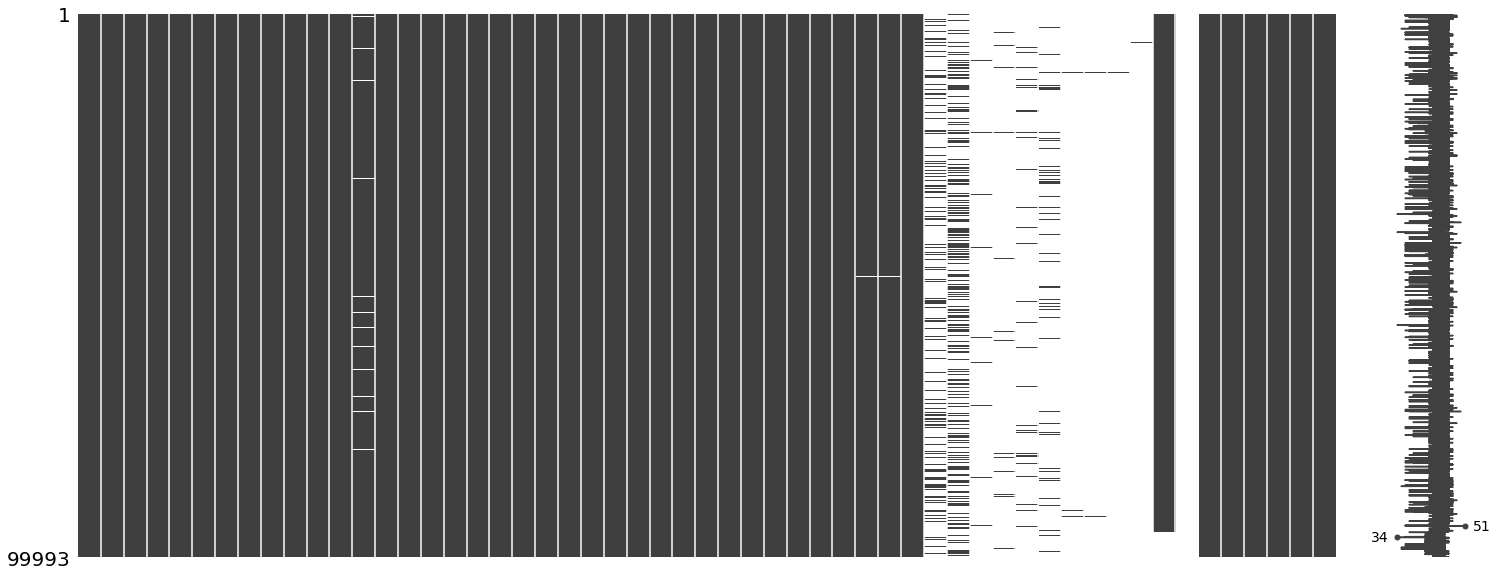

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99993 entries, 96109 to 0
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   crash_record_id                99993 non-null  object        
 1   crash_date                     99993 non-null  datetime64[ns]
 2   posted_speed_limit             99993 non-null  int64         
 3   traffic_control_device         99993 non-null  object        
 4   device_condition               99993 non-null  object        
 5   weather_condition              99993 non-null  object        
 6   lighting_condition             99993 non-null  object        
 7   first_crash_type               99993 non-null  object        
 8   trafficway_type                99993 non-null  object        
 9   alignment                      99993 non-null  object        
 10  roadway_surface_cond           99993 non-null  object        
 11  road_defect    

In [18]:
#Visualising missing data
#Sorting values by crash date
collisions = collisions.sort_values(by='crash_date',ascending=True)

#plotting matrix of missing data
msno.matrix(collisions)
plt.show()

#info of sorted data
print(collisions.info())

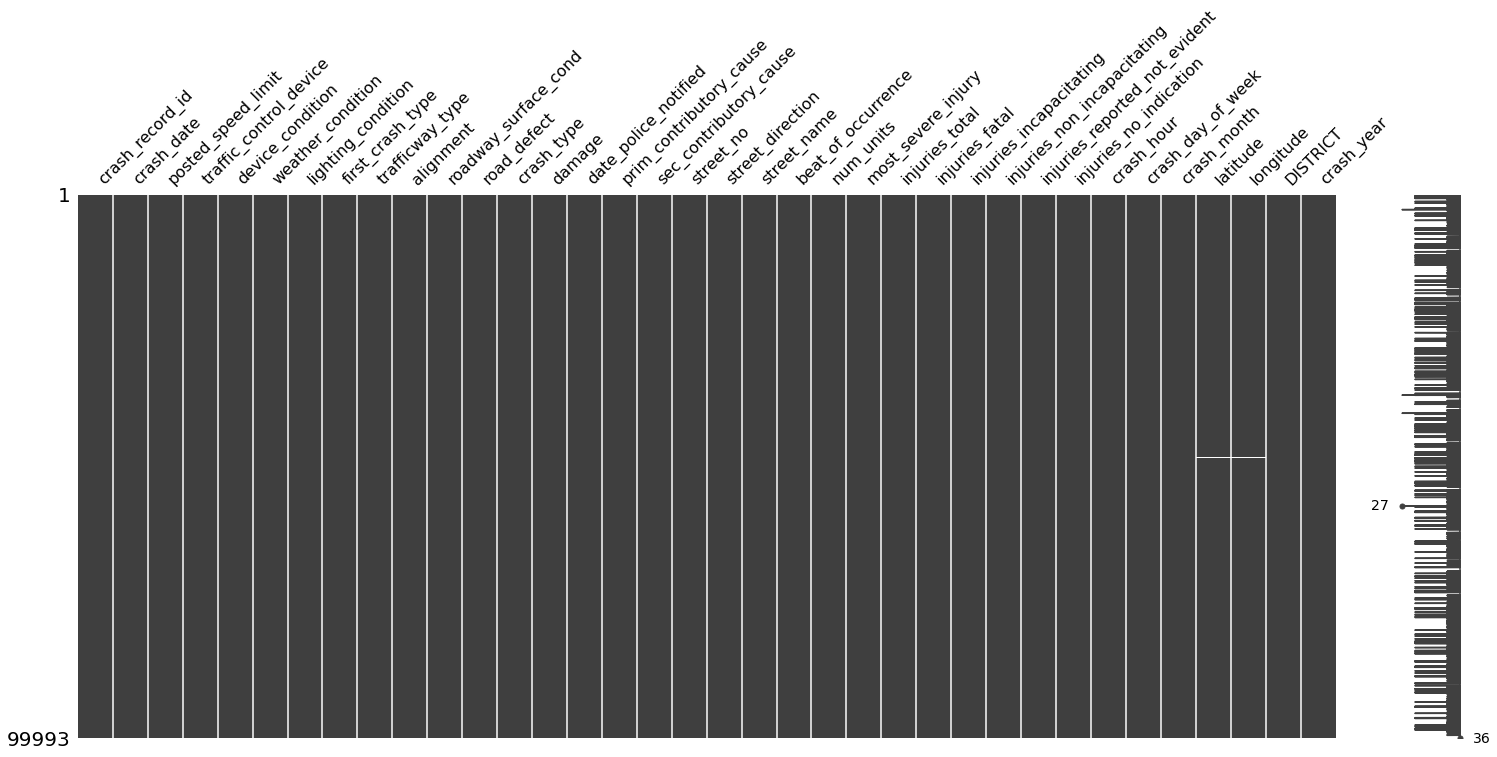

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99993 entries, 96109 to 0
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   crash_record_id                99993 non-null  object        
 1   crash_date                     99993 non-null  datetime64[ns]
 2   posted_speed_limit             99993 non-null  int64         
 3   traffic_control_device         99993 non-null  object        
 4   device_condition               99993 non-null  object        
 5   weather_condition              99993 non-null  object        
 6   lighting_condition             99993 non-null  object        
 7   first_crash_type               99993 non-null  object        
 8   trafficway_type                99993 non-null  object        
 9   alignment                      99993 non-null  object        
 10  roadway_surface_cond           99993 non-null  object        
 11  road_defect    

In [19]:
#defining unnecessary columns
drop_cols = ['location', 'crash_date_est_i','report_type', 'intersection_related_i',
       'hit_and_run_i', 'photos_taken_i', 'crash_date_est_i', 'injuries_unknown',
       'private_property_i', 'statements_taken_i', 'dooring_i', 'work_zone_i',
       'work_zone_type', 'workers_present_i','lane_cnt','the_geom','rd_no',
            'SECTOR','BEAT','BEAT_NUM']

#dropping columns
collisions=collisions.drop(columns=drop_cols)

#plotting matrix of missing data
msno.matrix(collisions)
plt.show()

#info of sorted data
print(collisions.info())

In [20]:
#drop all rows with missing latitude/longitude data
collisions.dropna(subset=['longitude','latitude'],inplace=True)

#replacing all null values in injuries columns with 0
#defining injury columns
num_injury_cols = ['injuries_total','injuries_fatal','injuries_incapacitating',
                  'injuries_non_incapacitating','injuries_reported_not_evident',
                  'injuries_no_indication']
collisions[num_injury_cols] = collisions[num_injury_cols].fillna(0)


In [21]:
#Some incorrect lat/long data - need to remove these rows
collisions = collisions[collisions['longitude']<-80]
collisions = collisions[collisions['latitude']>40]

In [22]:
print(collisions.describe())

       posted_speed_limit     street_no  beat_of_occurrence     num_units  \
count        99097.000000  99097.000000        99097.000000  99097.000000   
mean            28.595780   3747.152235         1254.895971      2.037045   
std              5.587121   2825.150354          703.171682      0.469492   
min              0.000000      1.000000          111.000000      1.000000   
25%             30.000000   1400.000000          725.000000      2.000000   
50%             30.000000   3300.000000         1213.000000      2.000000   
75%             30.000000   5564.000000         1823.000000      2.000000   
max             65.000000  13787.000000         2535.000000     18.000000   

       injuries_total  injuries_fatal  injuries_incapacitating  \
count    99097.000000    99097.000000             99097.000000   
mean         0.206333        0.001443                 0.021777   
std          0.589665        0.041515                 0.174196   
min          0.000000        0.000000     

In [23]:
##########################################
#Step 5: Plot data
##########################################

<Figure size 1440x864 with 0 Axes>

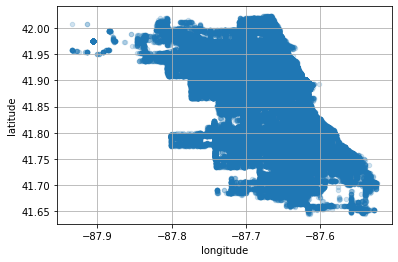

In [24]:
#setting range of plot to be the minimum/maximum values for lat/long

#plotting lat/long data showing locations of crashes
plt.figure(figsize=(20,12))
collisions.plot(kind='scatter',x='longitude',y='latitude',grid=True,alpha=0.2)

plt.show()

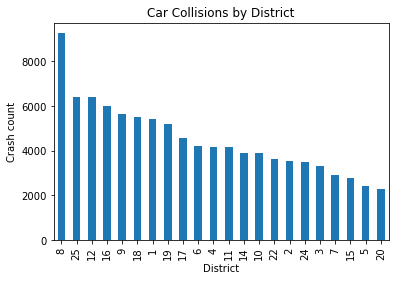

In [25]:
#plot graphs of collisions by district
district_count = collisions['DISTRICT'].value_counts()

district_count.plot.bar()
plt.xlabel('District')
plt.ylabel('Crash count')
plt.title('Car Collisions by District')
plt.show()

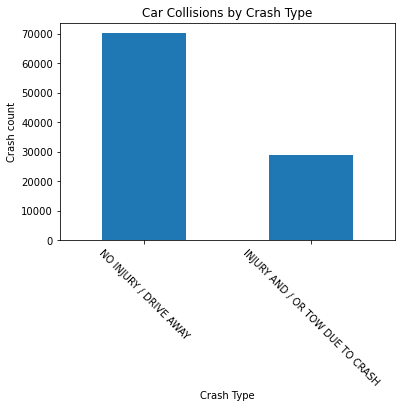

In [26]:
#plot graphs of crash type 
crash_type_count = collisions['crash_type'].value_counts()

crash_type_count.plot.bar()
plt.xlabel('Crash Type')
plt.ylabel('Crash count')
plt.title('Car Collisions by Crash Type')
plt.xticks(rotation=-45)
plt.show()

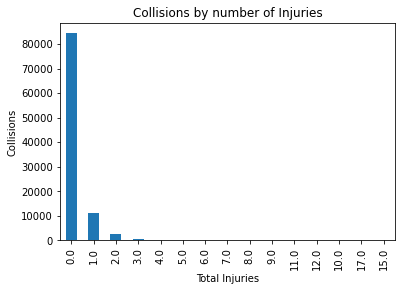

In [27]:
#plot graphs of collisions by number of injuries
injuries_total_count = collisions['injuries_total'].value_counts()

injuries_total_count.plot.bar()
plt.xlabel('Total Injuries')
plt.ylabel('Collisions')
plt.title('Collisions by number of Injuries')
plt.show()

In [28]:
##########################################
#Step 6: Machine Learning
##########################################

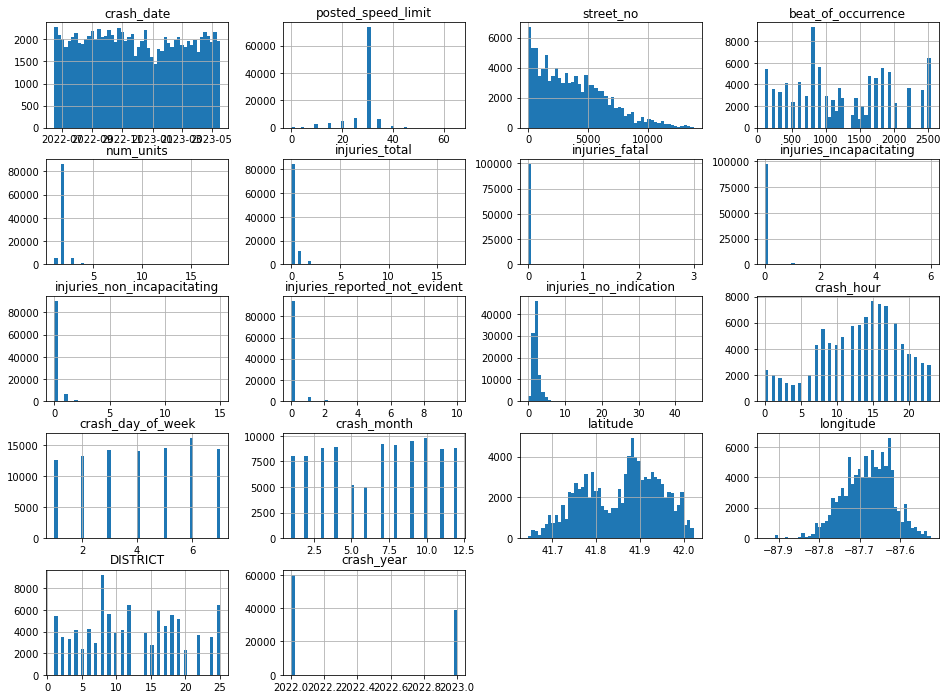

In [29]:
#plotting histograms of numerical values
collisions.hist(bins=50,figsize=(16,12))
plt.show()

In [30]:
ml_cols = ['posted_speed_limit','traffic_control_device', 'device_condition', 'weather_condition',
          'lighting_condition', 'first_crash_type', 'trafficway_type','alignment', 
           'roadway_surface_cond', 'road_defect', 'crash_type','damage','prim_contributory_cause',
          'sec_contributory_cause','street_direction','num_units', 'DISTRICT',
          'crash_hour','crash_day_of_week','latitude', 'longitude']
cat_cols = ['traffic_control_device', 'device_condition', 'weather_condition', 'DISTRICT',
           'lighting_condition', 'first_crash_type', 'trafficway_type','alignment',
           'roadway_surface_cond', 'road_defect', 'crash_type','damage','prim_contributory_cause',
           'sec_contributory_cause','street_direction','num_units']

collisions_ml = collisions[ml_cols].copy()

#encoding categorical values
label_encoder = LabelEncoder()
for col in collisions_ml[cat_cols].columns:
    collisions_ml[col] = label_encoder.fit_transform(collisions_ml[col])


In [31]:
#scaling latitude and longitude data
scaler = StandardScaler()

# Logarithmic transformation on longitude
collisions_ml['neg_log_longitude'] = scaler.fit_transform(np.log1p(-collisions_ml['longitude']).values.reshape(-1,1))

# Normalisation on latitude
collisions_ml['norm_latitude'] = scaler.fit_transform(collisions['latitude'].values.reshape(-1, 1))

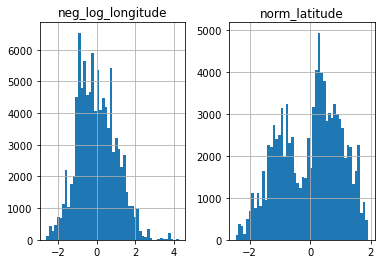

In [32]:
collisions_ml[['neg_log_longitude','norm_latitude']].hist(bins=50)
plt.show()

In [33]:
#transforming crash_hour 
#data is cyclic, can be encoded using trig transforms

#trig transformation - sin(crash_hr)
collisions_ml['sin_hr'] = np.sin(2*np.pi*collisions_ml['crash_hour']/24)


<AxesSubplot:>

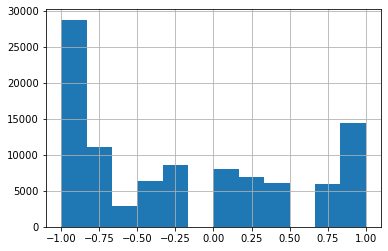

In [34]:
collisions_ml['sin_hr'].hist(bins=12)

In [35]:
#drop previous latitude/longitude columns
lat_long_drop_cols = ['longitude','latitude']
collisions_ml.drop(lat_long_drop_cols,axis=1,inplace=True)

#drop crash_hour column
collisions_ml.drop('crash_hour',axis=1,inplace=True)

In [36]:
#Create test set
#setting X and y values

X = collisions_ml.drop('crash_type', axis=1)
y = collisions_ml['crash_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
print(collisions_ml.head())

       posted_speed_limit  traffic_control_device  device_condition  \
96109                  30                       3                 3   
34450                  30                      15                 1   
45113                  10                       3                 3   
27991                  30                      15                 1   
72794                  30                      16                 3   

       weather_condition  lighting_condition  first_crash_type  \
96109                  2                   3                17   
34450                  2                   3                17   
45113                  2                   3                13   
27991                  2                   3                15   
72794                  2                   3                 7   

       trafficway_type  alignment  roadway_surface_cond  road_defect  ...  \
96109                8          3                     0            1  ...   
34450                6

In [51]:
#Classifier - K Nearest Neighbours
#instantiate KNN Classifier
KNNClassifier = KNeighborsClassifier(n_neighbors=10, metric = 'manhattan')

KNNClassifier.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10)

In [52]:
#Predictions
#predict on training set
y_train_pred = KNNClassifier.predict(X_train)

#predict on test data
y_test_pred = KNNClassifier.predict(X_test)

In [53]:
#Evaluate model
# Calculate the accuracy of the model

#calculating accuracy of model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)

#calculating accuracy of model on test data
test_accuracy = accuracy_score(y_test, y_test_pred)

#computing f1 score,precision,recall
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test,y_test_pred)
recall = recall_score(y_test,y_test_pred)

#comparing performances
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Train-Test Accuracy Difference:", train_accuracy-test_accuracy)

#print precision score
print("Precision Score:", precision)

#print recall score
print("Recall Score:", recall)

#print f1 score
print("F1 Score:", f1)

Training Accuracy: 0.7872649065933373
Test Accuracy: 0.7422805247225025
Train-Test Accuracy Difference: 0.044984381870834755
Precision Score: 0.779477891581314
Recall Score: 0.8878218807796272
F1 Score: 0.8301296973727966


In [50]:
#Fine tuning (RandomisedSearchCV)
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 7, 10],
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}

# instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=param_grid, cv=5)

# fit to training data
random_search.fit(X_train, y_train)

# Retrieve best model and performance
best_classifier = random_search.best_estimator_
best_accuracy = random_search.best_score_

print("Best Accuracy:", best_accuracy)
print("Best Model:", best_classifier)

Best Accuracy: 0.7405552797632174
Best Model: KNeighborsClassifier(metric='manhattan', n_neighbors=10)
